In [1]:
import pickle
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
import os
import requests
import pandas as pd
#from cStringIO import StringIO
import numpy as np
import matplotlib.pyplot as pl
import scipy as spy
from scipy.stats import gamma
from scipy.optimize import minimize
import emcee
import pystan
from pystan import StanModel
import stan_utility_copy
import corner
import gc
import seaborn as sns


In [2]:
periodInsolationSwitch = 'P' #raw_input("Period or Insolation: P or I? -- ")

In [3]:
with open("DR25_9.3_occ_rate_3000_real_Runcs.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
type(data_dict)
retrieved_results_real_uncs = data_dict['fit']


/Users/meganshabram/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [4]:
with open("DR25_9.3_occ_rate_3000_no_Runcs.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
type(data_dict)
retrieved_results_no_uncs = data_dict['fit']


/Users/meganshabram/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [5]:
alpha_real = retrieved_results_real_uncs['alpha']
beta_real = retrieved_results_real_uncs['beta']
lnf0_real = retrieved_results_real_uncs['lnf0']

PyStan_flatchain_real_uncs = np.hstack((lnf0_real.reshape(-1,1), beta_real.reshape(-1,1), alpha_real.reshape(-1,1)))


In [6]:
alpha_real = retrieved_results_no_uncs['alpha']
beta_real = retrieved_results_no_uncs['beta']
lnf0_real = retrieved_results_no_uncs['lnf0']

PyStan_flatchain_no_uncs = np.hstack((lnf0_real.reshape(-1,1), beta_real.reshape(-1,1), alpha_real.reshape(-1,1)))


In [7]:
# Integrate the planet density over a given range in period or insolation and radius
#   to get the exoplanet occurrence rate predicted by the power law in that region

def integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch):
    
    # Break out parameters 
    lnf0, beta, alpha = theta
    
    # Phase space boundaries for our model
    if(periodInsolationSwitch == 'P'):
        x_rng = (50, 300)
    elif(periodInsolationSwitch == 'I'):
        x_rng = (0.2, 20)
            
    radius_rng = (0.75, 2.5)
    
    # Compute exoplanet occurrence rate integrated over chosen region of [ x , radius] parameter space
    integral_over_x = (x2**(beta + 1) - x1**(beta + 1))/(x_rng[1]**(beta + 1) - x_rng[0]**(beta + 1))
    integral_over_radius = (radius2**(alpha + 1) - radius1**(alpha + 1))/(radius_rng[1]**(alpha + 1) - radius_rng[0]**(alpha + 1))
    eta = integral_over_x*integral_over_radius*np.exp(lnf0)
    
    return eta

In [8]:
%%time
!date
#  Compute and plot the posterior PDF for the exoplanet occurence rate in a 
#   desired region of period, radius parameter space
#   NOTE: using SAG-13 binning scheme

    
    #x1 = 160
    #x2 = 320
x1=50
x2=300

# !!!!! Choose radius bin edges for occurrence rate calculation
#radius1 = 1.0
#radius2 = 1.5
radius1 = .75
radius2 = 2.5



Thu May 10 18:39:29 PDT 2018
CPU times: user 5.62 ms, sys: 18 ms, total: 23.6 ms
Wall time: 142 ms


16, 50, 84 percentile range for integrated gamma = [0.40274315 0.48017747 0.57959401] 


(0, 1)

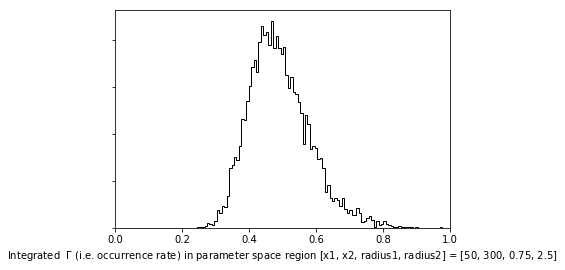

In [9]:

int_gamma_samples_real_uncs = np.empty(len(PyStan_flatchain_real_uncs))
for i, theta in enumerate(PyStan_flatchain_real_uncs):
    int_gamma_samples_real_uncs[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples_real_uncs,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples_real_uncs, 100, histtype="step", color="k")
#pl.hist(int_gamma_samples_small_uncs, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])


16, 50, 84 percentile range for integrated gamma = [0.35157338 0.40546805 0.46810479] 


(0, 1)

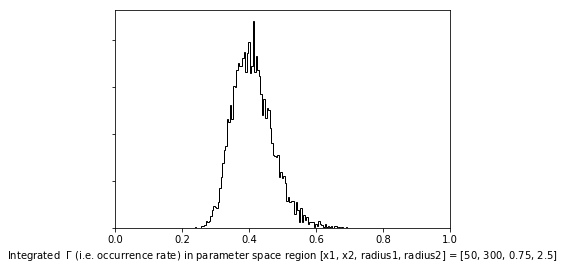

In [10]:
int_gamma_samples_no_uncs = np.empty(len(PyStan_flatchain_no_uncs))
for i, theta in enumerate(PyStan_flatchain_no_uncs):
    int_gamma_samples_no_uncs[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples_no_uncs,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples_no_uncs, 100, histtype="step", color="k")
#pl.hist(int_gamma_samples_small_uncs, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])


In [11]:
pl.rcParams["figure.figsize"] = (10,10)


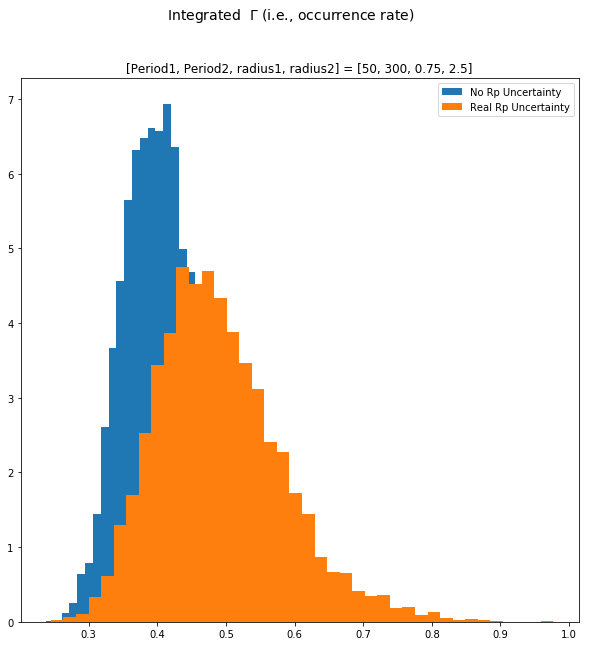

In [16]:

pl.hist(int_gamma_samples_no_uncs, 40, normed='true',label='No Rp Uncertainty')
#pl.hist(int_gamma_samples_small_uncs, 10, normed='true',label='Small Rp Uncertainty')
pl.hist(int_gamma_samples_real_uncs, 40, normed='true',label='Real Rp Uncertainty')
pl.suptitle(r"Integrated  $\Gamma$ (i.e., occurrence rate)", fontsize=14)    
pl.title("[Period1, Period2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
pl.legend()

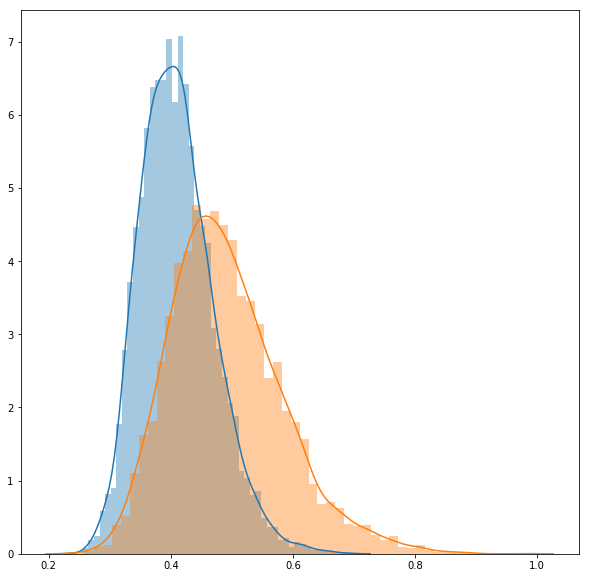

In [17]:
sns.distplot(int_gamma_samples_no_uncs)
sns.distplot(int_gamma_samples_real_uncs)
